In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u


In [2]:
#All Relevant nanapeaks functions

def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)

In [3]:
#Use your KIC or TIC ID here

search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
#Using the star's time data
#delta_f is defined as 1/(Total observation time), Hogg says its chosen by God aka it depends on the star
#we will manipulate delta_f when we make our frequency resolution
#The sampling rate finds the median time difference in the lightcurve data. For exmpale the data might be sampled
#every 25 or 30 minutes and we're finding the median across the star's time data.
##IMPORTANT!!! All lightcurve time data is in days!!! We must be careful with units or the units of our frequency will messed up

lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) ###frequency resolution in data
sampling_rate= np.median(np.diff(lc.time.value))
print(total_observation_time,sampling_rate)

1470.4622572100852 0.02043360086827306


In [5]:
#Setting an Maximum Frequency, Minimum Frequency, and Frequency grid
#right now we're setting our maximum frequency as 0.5/sampling rate, but we can also change it by a factor of 2,4,etc
#Hogg and I are still debating what the frequency domain should be (if it goes past 0.5/sampling this thing called mirroring happens)
f_max = (0.5 / (sampling_rate))

#for now this is what we want our minimum frequency to be
f_min = delta_f/3

#Frequency Grid
#This sets a specific frequency spacing when we make our periodogram.
#So we're saying start at the minimum frequency, go up to the maximum frequency and increment by fmin
#Units are so the program doesn't assume that it's in microhertz or that will cause a lot of problems
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)


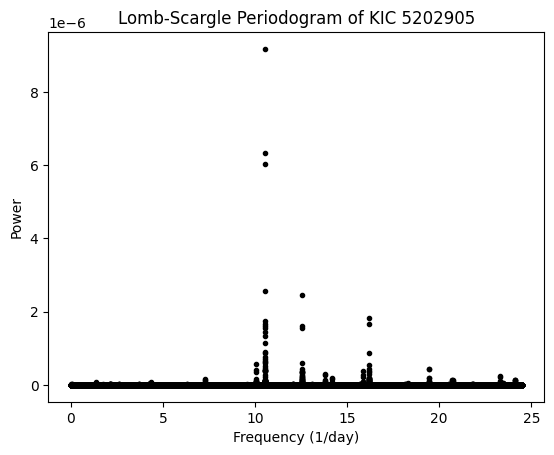

In [11]:
##Making our periodogram

pg = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

#Extract the frequency and power values.
#the to(1/u.day) is important because 
#when lightcurve uses to_periodogram(), it automatically converts to microhertz for some reason, so we must convert it back to days

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.show() 

In [7]:
### The function that we're using here "get_started" is described above
#Basically you choose the number of highest peaks you want from the periodogram and it returns the index of those peaks
#The peaks are ORDERED from highest to lowest

indices = get_started(100,freq,power)
print(indices)

[ 46500  46511  55437  71344  46487  46475  46504  46523  46507  55448
  44342  71355  85768  55424  69918  71332  55441  60773  55412 102738
  55444  71320  71348  55460  62557  32045  44353  46535 106301  71368
 106462  91376  91587  46483  71352  85778  46463  46429  44329  46471
  46515  85755  69929  46518  19131  60784  44317   5984  46571  55433
  69905  19242   5988 103395  60760  44346 102749  46481  46559  85772
  46459 102725  69922  85743  44365  46439  71340  44349  60777  55420
  55472  69893  80640  46609  32056  71328  46378  90609 106312  60748
  55408  53234  31989  16242  85775  69227  91598  46581  71379  55400
  91387  46468  69925 106473  55455  46493  55366  46491  91364  71307]


In [10]:
#refined_peaks is also described in detail more above
#It takes the indices of the highest peaks, frequency, and power and returned the more accurate frequency using a 
#parabolic fit
#It also returns the second derivative which we will use later to determine coherence

refined_freqs ,refined_powers, second_derivative = refine_peaks(freq,power,indices)

In [12]:
###We also need a threshold function, where the peaks must pass certain parameters based on its sharpess
#and it's surrounding region
#There's an example one below but 
#there's still problems with mirrored frequencies so we're not going to run through the threshold function yet

def threshold(indices, xs, ys):
    good_peaks = []
    for i in range(len(indices)):
        leftside = ys[indices[i]-10:indices[i]]  
        rightside = ys[indices[i]+1:indices[i]+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        if (ys[indices[i]] > 5*median) and (-second_derivative[i]/(y_new[i]))**(1/2) > total_observation_time:
            good_peaks.append(indices[i])

    return np.array(good_peaks)

In [36]:
##Below is also an uncessary function I created to determine the sharpness of the peaks
def sharpness(second_derivative, y_new, index):
    sharpness = (-second_derivative[index]/y_new[index])**(1/2)
    return sharpness

#I'm using index 0 because it's the highest peak
sharpness_example = sharpness(second_derivative, refined_powers, 0)

In [37]:
##Below is another function I created to look at the median of the 10delta_f region surrounding (and not including) the peak

def median(indices, xs, ys):
    good_medians = []
    for i in indices:
        leftside = ys[i-10:i]  
        rightside = ys[i+1:i+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        good_medians.append(median)
    return np.array(good_medians)

median_example = median(indices, freq, power)
print(median_example[0])

3.2283696701396636e-07


3563.0485693467685


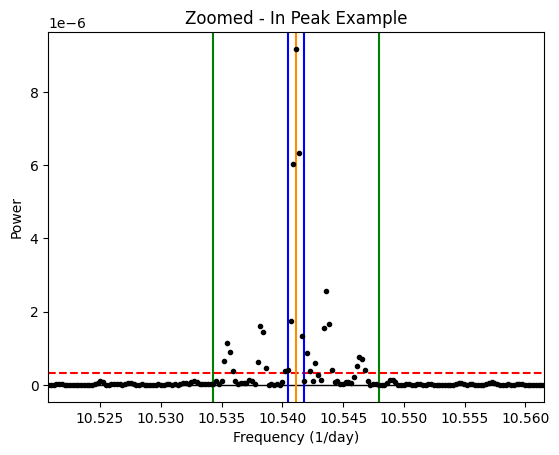

In [39]:
#Here is just a zoomed in example peak
#lines at 1 delta_f and 10 delta_f and one at the refined peak
#Red dash is the median in the 10delta_f region

plt.title("Zoomed - In Peak Example")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = median_example[0], color = 'r', linestyle = '--')
plt.axvline(x = refined_freqs[0], color = 'darkorange')
plt.axvline(x = refined_freqs[0]-delta_f, color = 'b')
plt.axvline(x = refined_freqs[0]+delta_f, color = 'b')
plt.axvline(x = refined_freqs[0]-10*delta_f, color = 'g')
plt.axvline(x = refined_freqs[0]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(freq, power, 'k.')
plt.xlim(refined_freqs[0]-30*delta_f, refined_freqs[0]+30*delta_f)
print(sharpness_examples)

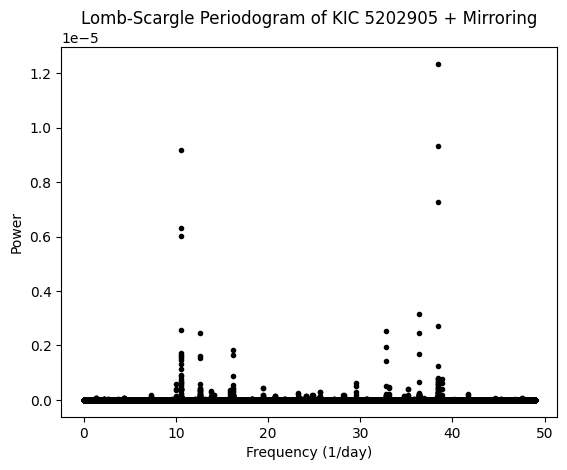

In [40]:
#A problem that we're facing is mirroring
#Currently our max frequency is around 24 (which we determined with our sampling rate)
#however if we increase that by a factor of 2 or 4, we will start
#to see mirroring in the frequency

new_f_max = f_max*2

new_frequency_grid = frequency_grid = np.arange(f_min, new_f_max, f_min)/(u.day)

pg_new = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

#Extract the frequency and power values.
#the to(1/u.day) is important because 
#when lightcurve uses to_periodogram(), it automatically converts to microhertz for some reason, so we must convert it back to days

power_new = pg_new.power.value
freq_new = pg_new.frequency.to(1/u.day).value 

plt.plot(freq_new, power_new,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905 + Mirroring")
plt.show() 

In [41]:
##If you look at the periodogram, we can see that it looks kinda symmetric reflected across frequency 24
# Which is the original max freq 
#Hogg says that those reflected frequencies may be the real coherent mode 
#so we must somehow determine a way to find the true coherent frequency with Erin's characterization process